# Part 1: Historical Data and Stock Betas Analysis 

### Step1: Data Collection 

In [24]:
#Install yfinance lib
!pip install yfinance

In [2]:
# Importing necessary libraries
import numpy as np  # library for numerical operations
import pandas as pd  # library for data manipulation and analysis
import yfinance as yf  # library to download financial data from Yahoo Finance
import warnings  # library for handling warnings
import pandas_datareader as pdr


# Defining the start and end dates for the period we want to study (10Y)
start = '2013-01-02'
end = '2022-12-31'

# Defining the ticker symbols for the companies we are interested in
tickers = ['RACE', 'TSLA', 'JPM', 'AMZN', '^GSPC', '^IRX']
my_assets = ['RACE', 'TSLA', 'JPM', 'AMZN']

# Downloading the historical data for the selected ticker symbols over the defined period
data = yf.download(tickers,
                 start=start,
                 end=end,
                 progress=False)  # Download progress will not be displayed


# Calculating the percentage change in prices to get returns and dropping the first row (NaN value)
portfolio_data = data['Adj Close'].resample('W') \
                   .last() \
                   .pct_change() 

portfolio_data = portfolio_data.iloc[1:]

# Displaying the first few rows of the portfolio data
portfolio_data.head(5)

AMZN       JPM  RACE      TSLA     ^GSPC      ^IRX
Date                                                              
2013-01-13  0.033919  0.017196   NaN -0.043314  0.003805 -0.030769
2013-01-20  0.015600  0.006936   NaN  0.048921  0.009463  0.111111
2013-01-27  0.043620  0.015066   NaN  0.071263  0.011427  0.000000
2013-02-03 -0.066869  0.014631   NaN  0.035695  0.006793 -0.142857
2013-02-10 -0.011509  0.016301   NaN  0.024543  0.003146  0.083333

<b>Note: </b> The historical data for all tickers is available since 2013, except for RACE, which has data available only from 2015-10-21. Therefore, when performing the regression analysis, the information about RACE will be considered starting from its available date in 2015, while the other tickers will be analyzed for the entire period since 2013.

### Step 2: Beta Estimation

The following code generates an OLS regression for the beta. The stock AMZN was selected.

In [3]:
import statsmodels.api as sm

# The risk-free rate is annual, so it is divided by 52 to get the weekly rate
Rm_Rf = portfolio_data['^GSPC']- portfolio_data['^IRX']*0.01/52

# Adding a constant to our independent variables for our regression analysis
Rm_Rf = sm.add_constant(Rm_Rf).rename(columns={'const' : 'Constant', 0: 'Rm_Rf'})

# Fitting an ordinary least squares (OLS) regression model
capm_model = sm.OLS(portfolio_data['AMZN'],Rm_Rf).fit()
print(capm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   AMZN   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     220.7
Date:                Fri, 21 Jul 2023   Prob (F-statistic):           7.40e-42
Time:                        18:38:29   Log-Likelihood:                 1001.5
No. Observations:                 521   AIC:                            -1999.
Df Residuals:                     519   BIC:                            -1990.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant       0.0024      0.002      1.523      0.1

### Step 3: Reporting

The following code generates an OLS regression of beta for each of the four tickers

In [26]:
import statsmodels.api as sm

# The risk-free rate is annual, so it is divided by 52 to get the weekly rate
Rm_Rf = portfolio_data['^GSPC']- portfolio_data['^IRX']*0.01/52

# Adding a constant to our independent variables for our regression analysis
Rm_Rf = sm.add_constant(Rm_Rf).rename(columns={'const' : 'Constant', 0: 'Rm_Rf'})

results_dict = {} 

for asset in my_assets:
    # Fitting an ordinary least squares (OLS) regression model
    df_portfolio = portfolio_data[asset]
    df_Rm_Rf = Rm_Rf.copy()
        
    if asset == 'RACE':
        df_portfolio = df_portfolio.dropna()
        df_Rm_Rf = Rm_Rf[Rm_Rf.index >= df_portfolio.index.min()]
        
    capm_model = sm.OLS(df_portfolio,df_Rm_Rf).fit()
    
    # Store the results for each asset in the dictionary
    results_dict[asset] = {
        'Stock Name': asset,
        'Coefficient': capm_model.params['Rm_Rf'],
        'Standard deviation': df_portfolio.std(),
        'Number of observations': len(df_portfolio),
        'T-statistic': capm_model.tvalues['Rm_Rf']
    }
    
    print(capm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   RACE   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     160.1
Date:                Fri, 21 Jul 2023   Prob (F-statistic):           8.78e-31
Time:                        18:44:03   Log-Likelihood:                 737.07
No. Observations:                 375   AIC:                            -1470.
Df Residuals:                     373   BIC:                            -1462.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant       0.0028      0.002      1.596      0.1

Based on the provided output of the OLS regression results for each stock, we can see the following: <br>

In [27]:
# Print the results for all assets after the loop
for asset, results in results_dict.items():
    print(f"Asset: {results['Stock Name']}")
    print(f"Coefficient: {results['Coefficient']:.4f}")
    print(f"Standard deviation: {results['Standard deviation']:.4f}")
    print(f"Number of observations: {results['Number of observations']}")
    print(f"T-statistic: {results['T-statistic']:.4f}")
    print("\n")

Asset: RACE
Coefficient: 0.8862
Standard deviation: 0.0406
Number of observations: 375
T-statistic: 12.6543


Asset: TSLA
Coefficient: 1.6521
Standard deviation: 0.0791
Number of observations: 521
T-statistic: 12.3333


Asset: JPM
Coefficient: 1.1481
Standard deviation: 0.0358
Number of observations: 521
T-statistic: 24.4616


Asset: AMZN
Coefficient: 1.0131
Standard deviation: 0.0423
Number of observations: 521
T-statistic: 14.8563




### Step 4: Comparison of Betas

<ul>
    <li>RACE has a beta of 0.8862, indicating that its returns are less sensitive to market changes. It tends to be less volatile than the overall market. Although Ferrari is a luxury goods company, it is actually resillient under recession, because of its loyal clients and long waiting lists to get these vehicles. <i>(Information about RACE is considered starting from its available date in 2015)</i></li>
    <li>TSLA has the highest beta of 1.6521, making it the most sensitive stock to market changes among the listed stocks. TSLA tends to be more volatile than the market, and its returns are strongly influenced by market movements. These is to be expected, as electric vehicles may have a lot of potential but they are still considered to be in a growth phase with uncertainty around mass adoption and infraestructure. 
        </li>
    <li>JPM has a beta of 1.1481, suggesting that it is more sensitive to market changes than RACE but less sensitive than TSLA. It moves more than the market but not as significantly as TSLA. Banks are sensible to markets movements and recessions, as their revenues depend on interest rates. However, JPM is in a mature banking industry with a lot of regulation, compared to TSLA who is an early stage industry.
        </li>
    <li>AMZN has a beta of 1.0131, very close to 1. This indicates that AMZN's returns move roughly in line with the market, making it relatively less volatile compared to TSLA. This would make sense, as amazon has a well diversified set of goods availabe in its platform, but movements in economic activity will affect the demand for its products.
        </li>
</ul>


In summary, among the listed stocks, TSLA is the most sensitive to market changes, exhibiting higher volatility compared to the overall market. RACE is the least sensitive, showing relatively lower volatility compared to the market. JPM and AMZN fall in between, with JPM being more sensitive to market changes than AMZN but less sensitive than TSLA.

### Step 5: Moving Window Regression

<AxesSubplot:title={'center':'Rolling Beta Estimate'}, xlabel='Date'>

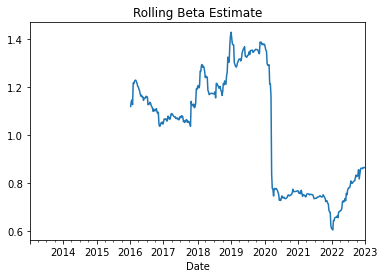

In [6]:
# Importing necessary libraries for the rolling regression
from statsmodels.regression.rolling import RollingOLS

# Define the start date and the number of weeks in the moving window
window_weeks = 157

# Create and fit the RollingOLS model
rols = RollingOLS(portfolio_data['AMZN'], Rm_Rf, window=window_weeks)
rolling_coefficients = rols.fit().params

# Plotting the rolling beta estimates (coefficients of 'Rm_Rf' variable)
rolling_coefficients['Rm_Rf'].plot(title ='Rolling Beta Estimate')

### Step 6: Plotting Beta Values

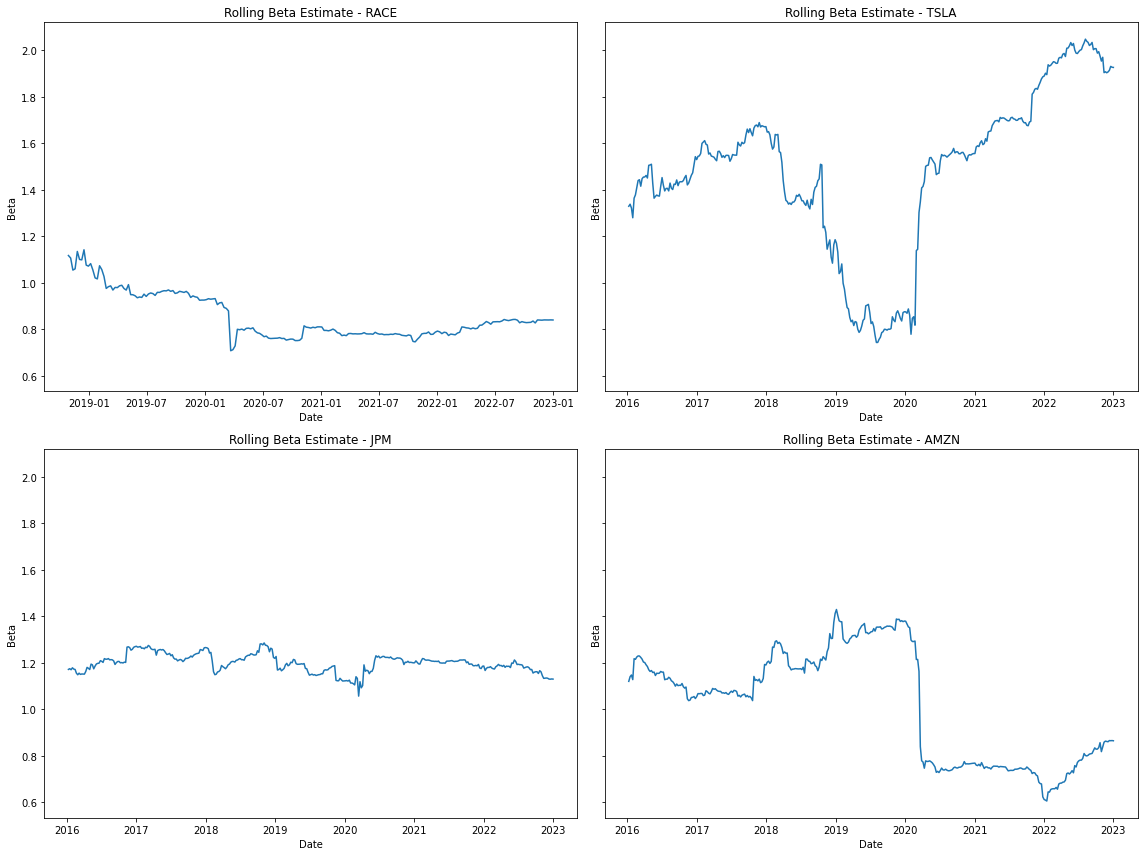

In [10]:
# Importing necessary libraries for the rolling regression
from statsmodels.regression.rolling import RollingOLS
from matplotlib import pyplot as plt

# Define the start date and the number of weeks in the moving window
window_weeks = 157

# Create a figure with four subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharey=True)

        
# Perform rolling regression analysis for each stock
for idx, asset in enumerate(my_assets):
    Retx = portfolio_data[asset]
    df_Rm_Rf = Rm_Rf.copy()
    
    if asset == 'RACE':
        Retx = Retx.dropna()
        df_Rm_Rf = Rm_Rf[Rm_Rf.index >= Retx.index.min()]
        
    # Create and fit the RollingOLS model
    rols = RollingOLS(Retx, df_Rm_Rf, window=window_weeks)
    rolling_coefficients = rols.fit().params

    # Display the rolling coefficients for the current window and stock
    rolling_coefficients
    
    row_idx = idx // 2
    col_idx = idx % 2
    
    # Plot the rolling beta estimates (coefficients of 'Rm_Rf' variable) for the current stock
    axes[row_idx, col_idx].plot(rolling_coefficients['Rm_Rf'], label='Rolling Beta Estimate')
    axes[row_idx, col_idx].set_title(f'Rolling Beta Estimate - {asset}')
    axes[row_idx, col_idx].set_xlabel('Date')
    axes[row_idx, col_idx].set_ylabel('Beta')
        
# Adjust layout and spacing between subplots
plt.tight_layout()

# Display all four plots
plt.show()

### Step 7: Interpreting the Shift in Tesla's Beta Value Pre and Post Mid-2020 

Going into 2019, the success of various Tesla models and diversification of the company's revenue (i.e solar energy, among others) should have reduced the risk of the stock and less correlated to the market. However, in 2020, The Pandemic and the resulting possibilities of working from home made the growth prospects of mass produced electric vehicles more uncertain, thus making the stock riskier again. We could argue that the more frequent online presence of its CEO in the latest years has made the stock substantially more volatile.

# Part 2: Geometric Brownian Motion Simulations and Portfolio Value Distribution 

### Step1: Data Collection 

In [11]:
# Defining the start and end dates for the period we want to study
start = '2021-07-01'
end = '2023-06-30'
T = 252  # Number of trading days in a year
N_SIMS = 10000  # Number of simulations to be performed

# Defining the ticker symbols for the companies we are interested in
tickers2 = ['INTC', 'AA', 'PFE', 'JPM']

# Defining the initial portfolio value
PORTFOLIO_VALUE = 1000

# Calculating the amount of money to be invested in each asset for an equal-weighted portfolio
VALUE_PER_ASSET = PORTFOLIO_VALUE / len(tickers2) 

# Downloading the historical data for the selected ticker symbols over the defined period
data2 = yf.download(tickers2,start=start,end=end)  # Download progress will not be displayed

adj_close = data2['Adj Close'].resample('W').last()  

# Calculating the daily returns
returns = adj_close.pct_change().dropna()

# Displaying the first few rows of the portfolio data
returns.head(5)

[*********************100%***********************]  4 of 4 completed


AA      INTC       JPM       PFE
Date                                              
2021-07-11 -0.012658 -0.013566 -0.001666 -0.003020
2021-07-18 -0.119925 -0.018217 -0.024780  0.018682
2021-07-25  0.124735 -0.035838 -0.008361  0.032962
2021-08-01  0.083378  0.013585  0.007568  0.036414
2021-08-08  0.013948  0.010245  0.037686  0.052792

### Step 2: Parameter calculation with 2-year sample and simulation 

In [12]:
# Calculating the number of shares of each asset to be bought, based on the last available price
SHARES = VALUE_PER_ASSET / adj_close.values[len(adj_close)-1, :]  
np.round(SHARES, 0) # Rounding the number of shares to the nearest whole number


# Computing the covariance matrix of the returns
cov_mat = returns.cov()  

# Performing a Cholesky decomposition of the covariance matrix
chol_mat = np.linalg.cholesky(cov_mat)  

In [13]:
# Generating normally distributed random numbers and applying the Cholesky matrix to induce correlation

# Generating random variates
rv = np.random.normal(size=(N_SIMS, len(tickers2))) 

# Applying Cholesky decomposition
correlated_rv = np.transpose(np.matmul(chol_mat, np.transpose(rv)))

# Displaying the correlated random variables
display(correlated_rv)

array([[ 0.00950973, -0.0143199 ,  0.0066582 ,  0.07397251],
       [ 0.04839914,  0.02742876,  0.02431094,  0.03890903],
       [ 0.02179421, -0.00585745,  0.03922446,  0.01608262],
       ...,
       [ 0.01515544,  0.01199113,  0.03888492, -0.0280838 ],
       [-0.00986638,  0.02540007,  0.01823346, -0.0342436 ],
       [-0.22716817, -0.05065096, -0.06853063,  0.04834597]])

In [14]:
r = np.mean(returns, axis=0).values  # Mean returns for each asset
sigma = np.std(returns, axis=0).values  # Standard deviation of returns for each asset
S_0 = adj_close.values[(len(adj_close)-1), :]  # Initial asset prices
P_0 = np.sum(SHARES * S_0)  # Initial portfolio value


In [15]:
# Simulating the price of each asset at the end of the period using geometric Brownian motion
S_T = S_0 * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * correlated_rv)

# Calculating the portfolio value at the end of the period
P_T = np.sum(SHARES * S_T, axis=1) 

# Calculating the difference between the final and initial portfolio values
P_diff = P_T - P_0 

### Step 3: Analysis of simulation results 

Portfolio Value Histogram:


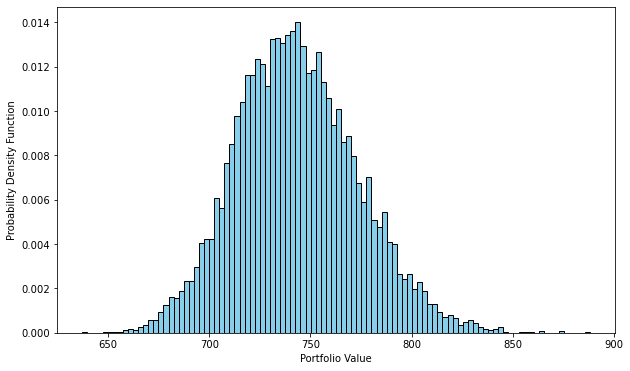

In [16]:
print('Portfolio Value Histogram:')
plt.figure(figsize=(10, 6))
plt.hist(P_T, bins=100, density=True, stacked=True, color='skyblue', edgecolor='black')
plt.xlabel('Portfolio Value')
plt.ylabel('Probability Density Function')
plt.show()

#### Summary statistics:

In [17]:
# Adding print statement for mean returns
print(f"Mean returns (r): {r}")

# Adding print statement for standard deviation of returns
print(f"Standard deviation of returns (sigma): {sigma}")

# Adding print statement for initial asset prices
print(f"Initial asset prices (S_0): {S_0}")

# Adding print statement for initial portfolio value
print(f"Initial portfolio value (P_0): {P_0}")

Mean returns (r): [ 0.0029999  -0.00341495  0.00041232  0.00049593]
Standard deviation of returns (sigma): [0.08872848 0.04829747 0.03800451 0.03885108]
Initial asset prices (S_0): [ 33.75999832  32.90999985 142.45169067  36.11999893]
Initial portfolio value (P_0): 1000.0


### Step 4: Parameter calculation with 10-year sample and simulation

In [18]:
# Defining the start and end dates for the period we want to study
start = '2013-07-01'
end = '2023-06-30'
T = 252  # Number of trading days in a year
N_SIMS = 10000  # Number of simulations to be performed

# Defining the ticker symbols for the companies we are interested in
tickers2 = ['INTC', 'AA', 'PFE', 'JPM']

# Defining the initial portfolio value
PORTFOLIO_VALUE = 1000

# Calculating the amount of money to be invested in each asset for an equal-weighted portfolio
VALUE_PER_ASSET = PORTFOLIO_VALUE / len(tickers2) 

# Downloading the historical data for the selected ticker symbols over the defined period
data3 = yf.download(tickers2,start=start,end=end)  # Download progress will not be displayed

adj_close2 = data3['Adj Close'].resample('W').last()  

# Calculating the daily returns
returns2 = adj_close2.pct_change().dropna()

# Displaying the first few rows of the portfolio data
returns2.head(5)

[*********************100%***********************]  4 of 4 completed


AA      INTC       JPM       PFE
Date                                              
2013-07-14  0.037132 -0.006650  0.018152  0.030033
2013-07-21 -0.003704 -0.035983  0.021648  0.009719
2013-07-28  0.000000  0.009549 -0.001959  0.009625
2013-08-04 -0.012391 -0.001719  0.007850  0.008155
2013-08-11  0.035294 -0.021092 -0.034874 -0.005448

In [19]:
# Calculating the number of shares of each asset to be bought, based on the last available price
SHARES = VALUE_PER_ASSET / adj_close2.values[len(adj_close2)-1, :]  
np.round(SHARES, 0) # Rounding the number of shares to the nearest whole number


# Computing the covariance matrix of the returns
cov_mat2 = returns2.cov()  

# Performing a Cholesky decomposition of the covariance matrix
chol_mat2 = np.linalg.cholesky(cov_mat2)  

# Generating normally distributed random numbers and applying the Cholesky matrix to induce correlation

# Generating random variates
rv2 = np.random.normal(size=(N_SIMS, len(tickers2))) 

# Applying Cholesky decomposition
correlated_rv2 = np.transpose(np.matmul(chol_mat2, np.transpose(rv2)))

# Displaying the correlated random variables
display(correlated_rv2)

array([[-0.21252488, -0.06380054, -0.04002634, -0.00523907],
       [-0.0153501 ,  0.07135058,  0.00271456,  0.03867995],
       [-0.09247481, -0.02004183, -0.03467236, -0.01383237],
       ...,
       [ 0.1215739 ,  0.07588141,  0.02466357, -0.00459918],
       [ 0.0368922 , -0.00962877, -0.01784117,  0.03368808],
       [-0.04116856,  0.02018118, -0.02405063, -0.00610093]])

In [20]:
r2 = np.mean(returns2, axis=0).values  # Mean returns for each asset
sigma2 = np.std(returns2, axis=0).values  # Standard deviation of returns for each asset
S_02 = adj_close2.values[(len(adj_close2)-1), :]  # Initial asset prices
P_02 = np.sum(SHARES * S_0)  # Initial portfolio value

In [21]:
# Simulating the price of each asset at the end of the period using geometric Brownian motion
S_T2 = S_02 * np.exp((r - 0.5 * sigma2 ** 2) * T + sigma2 * np.sqrt(T) * correlated_rv2)

# Calculating the portfolio value at the end of the period
P_T2 = np.sum(SHARES * S_T2, axis=1) 

# Calculating the difference between the final and initial portfolio values
P_diff2 = P_T2 - P_02 

### Step 5: Analysis of simulation and comparison with earlier version

Portfolio Value Histogram:


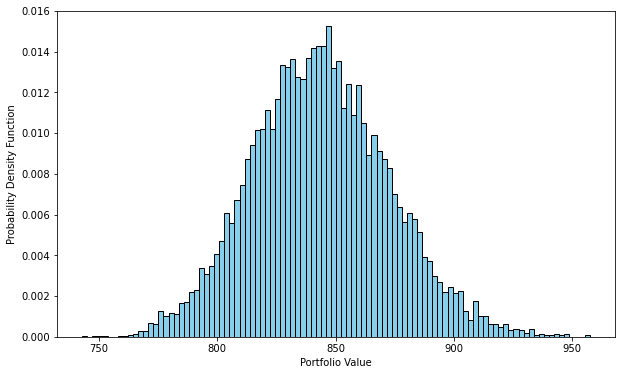

In [22]:
print('Portfolio Value Histogram:')
plt.figure(figsize=(10, 6))
plt.hist(P_T2, bins=100, density=True, stacked=True, color='skyblue', edgecolor='black')
plt.xlabel('Portfolio Value')
plt.ylabel('Probability Density Function')
plt.show()

#### Summary statistics:

In [23]:
# Adding print statement for mean returns
print(f"Mean returns (r): {r2}")

# Adding print statement for standard deviation of returns
print(f"Standard deviation of returns (sigma): {sigma2}")

# Adding print statement for initial asset prices
print(f"Initial asset prices (S_0): {S_02}")

# Adding print statement for initial portfolio value
print(f"Initial portfolio value (P_0): {P_02}")

Mean returns (r): [0.00396893 0.00198691 0.00305541 0.00174987]
Standard deviation of returns (sigma): [0.07360145 0.04035825 0.03618504 0.03052626]
Initial asset prices (S_0): [ 33.75999832  32.90999985 142.45169067  36.11999893]
Initial portfolio value (P_0): 1000.0


#### Differences, if any, in the distribution of final values generated from the 2-year and 10-year parameter simulations


<ul>
        <li><strong>Mean Returns:</strong> Both simulations show moderate growth. The 10-year one has slightly better growth, indicating improved long-term performance. (Across all assets)</li>

<li><strong>Standard Deviation of Returns:</strong> The 2-year simulation is more volatile, while the 10-year one is more stable.
</ul>
Overall the 10-year simulation offers a comprehensive view for long-term planning. Short-term is useful for quick decisions and understanding current trends.

#### Reflect on why these differences may exist and what they imply about the use of different time spans in parameter estimation


Using data from the past 10 years gives a better understanding of the stock's overall performance, including long-term trends and market behavior. This makes the expected return estimate more stable. However, relying on just the past 2 years may result in a more uncertain estimate due to recent market fluctuations and short-term events, which might not reflect the stock's long-term behavior accurately.